In [5]:
from keras.engine import *
from keras.engine.topology import Container
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import *
import numpy as np
import keras.backend as K
from functools import reduce
from tqdm import tqdm_notebook
from keras.utils.np_utils import to_categorical
from matplotlib import pylab as plt
from IPython.display import clear_output
from MeCab import Tagger
from recurrentshop import *

In [6]:
TEXT_LENGTH = 30

In [7]:
mecaber = Tagger("-Ochasen")
with open("./timeline/chahan69.txt", "r") as f:
    texts = []
    for line in f.readlines():
        pos = mecaber.parse(line).split("\n")[:-1]
        if len(pos) < 7:
            continue
        words = [x.split("\t")[0] for x in pos]
        texts.append(" ".join(words))
tokenizer = Tokenizer(lower=True)

In [8]:
tokenizer.fit_on_texts(texts)
X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=TEXT_LENGTH, padding="post")

In [34]:
def get_D():
#     def del0(tensor): return(tensor[:,:,1:])
    inputs = Input(shape=(None, len(tokenizer.word_index)+1))
#     y = Lambda(del0)(inputs)
#     y = Masking()(y)
    y = TimeDistributed(Dense(100))(inputs)
    y = LSTM(256)(y)
    y = Dense(100, activation="relu")(y)
    y = Dense(1, activation=("sigmoid"))(y)
    model = Container(inputs=inputs, outputs=y, name="d")
    return(model)

def get_G():
    inputs = Input(shape=(256,))
    rnn = RecurrentSequential(decode=True, output_length=50)
    rnn.add(LSTMCell(256))
    rnn.add(Dropout(0.1))
    rnn.add(LSTMCell(256))
    y = rnn(inputs)
    y = TimeDistributed(Dense(len(tokenizer.word_index)+1, activation="softmax"))(y)
    model = Container(inputs=inputs, outputs=y, name="g")
    return(model)

In [35]:
class InvTokenizer:
    def __init__(self, dic):
        self.dic = dic
        self.num = len(dic)
        self.invdec = ["" for _ in range(self.num + 1)]
        for c, i in self.dic.items():
            self.invdec[i] = c
    
    def __call__(self, array):
        array = array.argmax(axis=2)
        res = []
        for j in range(len(array)):
            res.append(reduce(lambda x,y:x+y,[self.invdec[int(i)] for i in list(array[j])]))
        return(res)
            
texgen = InvTokenizer(tokenizer.word_index)

In [36]:
dis = get_D()
gen = get_G()

gen_in = Input(shape=(256,))
y1 = gen(gen_in)
y2 = dis(y1)
dis_in = Input(shape=(None, len(tokenizer.word_index)+1))
dis_y = dis(dis_in)

G = Model(gen_in, y1)
G.compile(loss="binary_crossentropy", optimizer=RMSprop(1e-4))
D = Model(dis_in, dis_y)
D.compile(loss="binary_crossentropy", optimizer=RMSprop(1e-5))
dis.trainable = False
G_trainer = Model(gen_in, y2)
G_trainer.compile(loss="binary_crossentropy", optimizer=RMSprop(1e-4))
gen.trainable = False
dis.trainable = True
D_trainer = Model(gen_in, y2)
D_trainer.compile(loss="binary_crossentropy", optimizer=RMSprop(1e-5))
G_history = [] 
D_history = []

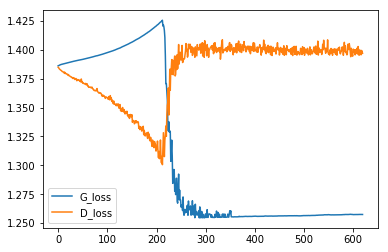

KeyboardInterrupt: 

In [37]:
epoch = 10
batch_size = 32
for e in range(epoch):
    np.random.shuffle(X)
    t = tqdm_notebook(range(0, len(X), batch_size)[:-1])
    for i in t:
        batch = np.array([to_categorical(x, num_classes=len(tokenizer.word_index)+1) for x in X[i:i+batch_size]])
        G_loss = G_trainer.train_on_batch(np.random.normal(size=(batch_size, 256)), np.zeros(batch_size))
        G_loss += G_trainer.train_on_batch(np.random.normal(size=(batch_size, 256)), np.zeros(batch_size))
        D_loss = D_trainer.train_on_batch(np.random.normal(size=(batch_size, 256)), np.ones(batch_size))
        D_loss += D.train_on_batch(batch, np.zeros(batch_size))
        
        G_history.append(G_loss)
        D_history.append(D_loss)
        t.set_description("G_loss: {0}, D_loss: {1}".format(G_loss, D_loss))
        clear_output()
        noise = np.random.normal(size=(1, 256))
        res = G.predict(noise)
        print(texgen(res)[0])
        plt.plot(G_history, label="G_loss")
        plt.plot(D_history, label="D_loss")
        plt.legend()
        plt.show()

In [18]:
texgen(G.predict(np.random.normal(size=(batch_size, TEXT_LENGTH, 100))))

['！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！',
 '！！！！！！！！！！！！！！！！！！